In [5]:

!pip install -qU pymupdf4llm Pillow langchain langchain-openai langchain-text-splitters langchain-chroma langchain_community langchain-pymupdf4llm langgraph


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import os

if not os.environ.get("OPENAI_API_KEY"):
    raise "OPENAI_API_KEY not set"

if not os.environ.get("LANGSMITH_API_KEY"):
    raise "LANGSMITH_API_KEY not set"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "ai-final"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

IMAGES_FOLDER = './storage/images'
TABLES_FOLDER = './storage/tables'

os.makedirs(IMAGES_FOLDER, exist_ok=True)
os.makedirs(TABLES_FOLDER, exist_ok=True)


In [7]:
import fitz
import io
from PIL import Image
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
import pymupdf4llm
import base64
from IPython.display import Markdown
from typing_extensions import List, TypedDict
from langchain import hub
from langchain.chat_models import init_chat_model
from langgraph.graph import START, StateGraph
import IPython.display


In [8]:
doc: fitz.Document = fitz.open("EPAM-Reports-Results-for-Fourth-Quarter-and-Full-Year-2024_4.pdf")

In [9]:
def summarize_images(images: list[str], prompt_template: str) -> list[str]:
    messages = [
        (
            "user",
            [
                {"type": "text", "text": prompt_template},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/png;base64,{image}"},
                },
            ],
        )
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()
    return chain.batch(images)

In [10]:

def extract_images(doc: fitz.Document, summarize: bool = True) -> list[Document]:
    documents: list[Document] = []
    images: list[str] = []
    for idx, page in enumerate(doc):
        for img in page.get_images(full=True):
            xref = img[0]
            base_image = doc.extract_image(xref)["image"]
            pil_image = Image.open(io.BytesIO(base_image))
            file = f"{IMAGES_FOLDER}/{idx}_{img[7]}.png"
            pil_image.save(file, "PNG")
            documents.append(
                Document(page_content="",
                         metadata=dict(doc.metadata, pdf=doc._name, page=page.number, file=file, type="image")))
            if summarize:
                images.append(base64.encodebytes(base_image).decode("ascii"))
    if summarize:
        summarized_images = summarize_images(images,
                                             "Describe the image in detail. For context, the image is part of a PDF document")
        for doc, summary in zip(documents, summarized_images):
            doc.page_content = summary
    return documents


documents_images = extract_images(doc)

In [11]:

def extract_tables(doc: fitz.Document, summarize: bool = True) -> list[Document]:
    documents: list[Document] = []
    images: list[str] = []
    for idx, page in enumerate(doc):
        tabs = page.find_tables()  # detect the tables
        for i, tab in enumerate(tabs):  # iterate over all tables
            pix = page.get_pixmap(clip=tab.bbox)
            file = f"{TABLES_FOLDER}/{idx}_{i}.png"
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            img.save(file, "PNG")
            buffered = io.BytesIO()
            img.save(buffered, format="PNG")
            documents.append(
                Document(page_content="",
                         metadata=dict(doc.metadata, pdf=doc._name, page=page.number, file=file, type="table")))
            if summarize:
                images.append(base64.encodebytes(buffered.getvalue()).decode("ascii"))
    if summarize:
        summarized_images = summarize_images(images,
                                             "Describe the image of the table in detail. For context, the image is part of a PDF document.")
        for doc, summary in zip(documents, summarized_images):
            doc.page_content = summary

    return documents


documents_tables = extract_tables(doc)


In [12]:

def extract_text(doc: fitz.Document) -> list[Document]:
    pages = pymupdf4llm.to_markdown(doc=doc, ignore_images=True, table_strategy=None, page_chunks=True)
    return [Document(page_content=page['text'], metadata=dict(page['metadata'], type='text')) for page in pages if
            len(page['text']) > 0]


documents_text = extract_text(doc)

In [13]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [14]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="aifinals_collection",
    embedding_function=embeddings,
    persist_directory="./storage/db",  # Where to save data locally, remove if not necessary
)

In [15]:
vector_store.add_documents(documents_tables)

['918dd11d-c369-4251-a892-3eb8cc30b576',
 'e76b2e20-d05a-4e07-b865-d871666d8424',
 'fb209b91-2a9c-47fa-9483-8c939ed1c099',
 '33fed900-4785-43c0-be64-49dec3f74478',
 '5809b5d6-6be7-4840-bbdb-9c99a193772b',
 '378fda03-5f45-4fdd-8b43-e4f9be0fd32d',
 'd2edda3c-ab57-4eed-b178-1badc5fdf214',
 'b5b73793-e788-478d-b3e2-68b13d3a9f9e',
 '08a8a773-2bb2-46e0-914a-7f7ec0b37119',
 '0817ce53-bbf5-419f-8d8e-6ee7896e91ed']

In [16]:
vector_store.add_documents(documents_images)

['3fa07ea0-d553-4a45-8de9-a2cdf22c3bfd',
 'b77b8b3e-a257-434a-bfce-6703a344cc5b',
 '570358d8-c2ca-4cc2-8c34-ea8ada74ac1e']

In [17]:
vector_store.add_documents(documents_text)

['ca8b9cfc-064c-4297-97e4-29af4e2dcbc1',
 '07e18acc-b434-4a1c-a137-c0b3e7c2f7db',
 'f3aaa02f-c77f-478d-b964-599fcf1bd891',
 'f603c5cb-aeb7-4cb0-a5e7-f6e52ca4ec84',
 '6d396cf0-3dc8-4570-8d54-370bec29f5f9',
 '6fe74ebf-95f3-4cef-9622-f2da63eedcf1',
 'f10f918c-7693-4e03-9827-5d1d36adda78',
 'c337914f-8562-4fda-a737-0ab1ecc27ef1',
 'c7f3158a-c984-4216-93df-8bee024ad26b',
 'f2f74e96-2a51-4b52-a8bb-81ba17e74fac',
 '61ed935b-697d-4159-917e-fbacd193668a',
 'e1d149c7-524a-458b-8a57-2499a3771b7b',
 '62532e82-e12e-4b8f-9936-73cbd84ef4bc']

918dd11d-c369-4251-a892-3eb8cc30b576


The image appears to depict a financial table, likely a part of an earnings report or financial statement. Here’s a detailed description:

1. **Structure**:
   - The table is divided into sections, with two main columns labeled “Three Months Ended December 31” for two separate years (2023 and 2024) and another section for the “Year Ended December 31” which follows the same year structure.

2. **Headers**:
   - The first row lists the headers including "Revenues," "Operating expenses," "Income from operations," and "Net income per share." Each section has subcategories that break down the respective financial figures.

3. **Content**:
   - **Revenues**: The first figures under revenues indicate total amounts for both years. 
   
   - **Operating Expenses**: This section includes various line items and their corresponding figures for both years. Notable entries include "Cost of revenues," "Selling, general, and administrative expenses," and "Depreciation and amortization expense."

   - **Income Calculations**: It calculates "Income from operations,” “Interest and other income, net,” and “Income before provision for income taxes.”

   - **Net Income**: The table concludes with net income figures for the three-month and year-end periods, detailing basic and diluted earnings per share.

4. **Numerical Details**: 
   - Each figure appears to be formatted with commas for thousands, showcasing the financial data clearly. For example, revenue figures such as $1,248,351 for 2024 are prominently displayed.

5. **Styling**:
   - The table is likely set against a clean background with alternating row colors or bold headings to enhance readability, emphasizing key figures like net income and revenues.

Overall, the table provides a comprehensive overview of financial performance over the specified periods, useful for analyzing trends in revenues and expenses.

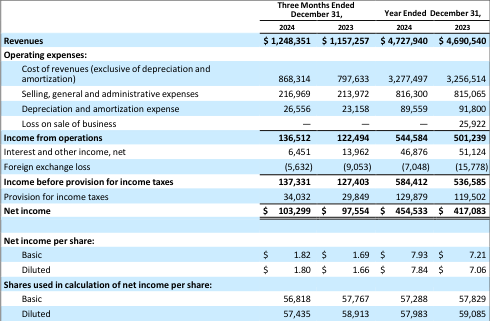

33fed900-4785-43c0-be64-49dec3f74478


The table presents financial data organized into two main sections: "Three Months Ended December 31, 2024" and "Year Ended December 31, 2024." Each section is divided into columns for GAAP (Generally Accepted Accounting Principles), adjustments, and non-GAAP figures. 

### Table Structure:

- **Columns**: 
  - The first column lists line items such as "Cost of revenues (exclusive of depreciation and amortization)," "Selling, general and administrative expenses," "Income from operations," "Operating margin," "Net income," and "Diluted earnings per share."
  - The subsequent columns break down the figures into GAAP, adjustments, and non-GAAP for both the three-month and year-end periods.

### Detailed Entries:

1. **Cost of Revenues**:
   - GAAP: $868,314
   - Adjustments: $(22,040)
   - Non-GAAP: $846,274
   - Yearly comparable figures show costs amounting to $3,277,497 under GAAP, with adjustments showing $(59,821), leading to a non-GAAP total of $3,217,676.

2. **Selling, General and Administrative Expenses**:
   - For the three-month period: GAAP shows $216,969, adjustments are $(37,637), yielding a non-GAAP figure of $179,332.
   - The yearly figures are also presented with GAAP totaling $816,300, and adjustments of $145,293 leading to a non-GAAP result of $670,971.

3. **Income from Operations**:
   - Three-month figures: GAAP shows $316,512, with adjustments of $(17,675) leading to a non-GAAP total of $208,487.
   - The yearly results show $544,584 under GAAP, adjustments of $234,625 adding up to a non-GAAP result of $779,209.

4. **Operating Margin**:
   - Three-month operating margin is shown as 10% under GAAP and 9.8% after adjustments.
   - For the year, the operating margin is 16.7% under GAAP and 16.5% after adjustments.

5. **Net Income**:
   - For the three-month period: GAAP shows $103,299, adjustments of $60,606, yielding a non-GAAP of $163,365.
   - Yearly totals show GAAP as $454,533, with adjustments of $175,430 giving a non-GAAP net income of $629,963.

6. **Diluted Earnings per Share**:
   - For three months, GAAP is $1.80, with non-GAAP at $2.84.
   - The year shows GAAP at $7.84, non-GAAP results in $10.86.

### Visual Elements:
- **Color Coding**: The table employs shading to differentiate between main categories and highlight various sections, aiding readability.
- **Formatting**: Figures are aligned for easy comparison, with numerical data likely being formatted to read thousands easily.

Overall, the table provides a comprehensive comparative financial overview for the specified periods, breaking down revenue and expense categories comprehensively.

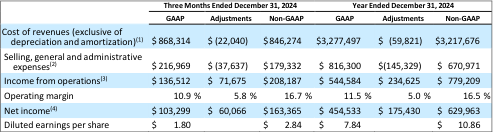

378fda03-5f45-4fdd-8b43-e4f9be0fd32d


The image presents a detailed table comparing financial data across multiple categories for two different periods: the three months ended December 31 and the year ended December 31, for the years 2023 and 2024. 

### Table Breakdown:

1. **Header Section**: 
   - The first two columns indicate the "Three Months Ended December 31" for the years 2023 and 2024.
   - The last two columns represent the "Year Ended December 31" for the same years.

2. **Categories Listed**:
   - **Stock-based compensation expenses**: The table shows amounts for Poland R&D incentives, humanitarian support in Ukraine, and other stock-based compensation categories delineated for clarity.
   - **Adjustments to GAAP (Generally Accepted Accounting Principles)**: 
     - These adjustments include various expenses such as stock compensation, operational costs, and any other adjustments made to align with GAAP.
   - **General and Administrative Expenses**: This section breaks down specific costs like amortization of intangible assets, losses from the sale of business, and provisions for income taxes.
   
3. **Financial Values**:
   - Each category has specific numerical values assigned for each respective period. It displays the expenses or adjustments resulting in a net total adjustment to GAAP net income.
   - Notably, it highlights variations between each year, providing an insight into growth or decline in specified areas.

4. **Additional Information**:
   - Footnotes (indicated by numbers next to some entries) may offer further explanations or clarifications for the figures presented, including the nature of expenses or any relevant accounting notes.

Overall, the table serves as an analytical tool to compare financial performance and adjustments over the specified periods, aiding in understanding the company's fiscal health and operational changes.

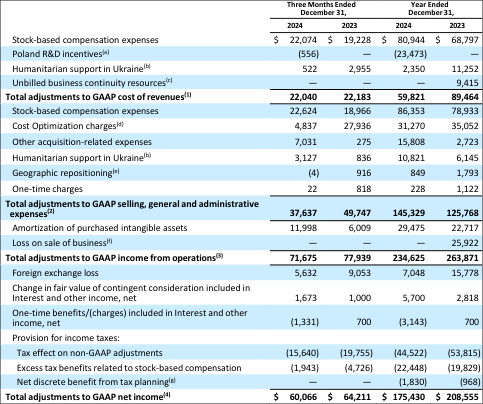

08a8a773-2bb2-46e0-914a-7f7ec0b37119


The image depicts a table containing financial data related to effective tax rates for the time periods of the first quarter of 2023 and the full year of 2023. 

### Table Structure and Content

- **Header Row:** 
  - The top section has two columns indicating the periods: "First Quarter 2023" and "Full Year 2023." 

- **First Row:**
  - **GAAP Effective Tax Rate (approximately):** 
    - Under "First Quarter 2023," the rate is listed as 19%.
    - Under "Full Year 2023," the rate is noted as 24%.

- **Second Row:**
  - **Excess Tax Benefits Related to Stock-Based Compensation:**
    - In the first quarter, it is 7.5%.
    - For the full year, it drops to 2.6%.

- **Third Row:**
  - **Tax Effect on Non-GAAP Adjustments:** 
    - This section shows a negative value of (2.5%) for the first quarter and (2.6%) for the full year.

- **Last Row:**
  - **Non-GAAP Effective Tax Rate (approximately):**
    - This is calculated based on the preceding values, indicating 24% for the first quarter and 24% for the full year.

### Design and Presentation
- The rows are clearly organized, with headings and corresponding percentages set against a primarily white background.
- The table appears to be visually structured for clarity, with alternating background shades for sections, making it easy to read.

This table summarizes key tax-related figures for financial reporting, providing insights into the effective tax rates based on GAAP and non-GAAP standards.

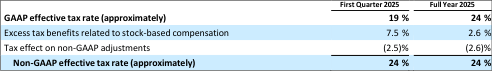

In [18]:
def display_documents(documents: list[Document]):
    sorted_documents = sorted(documents, key=lambda x: x.metadata['page'], reverse=False)
    for doc in sorted_documents:
        print(doc.id)
        display(Markdown(doc.page_content))
        if doc.metadata['type'] == 'image':
            display(Image.open(doc.metadata['file']))
        elif doc.metadata['type'] == 'table':
            display(Image.open(doc.metadata['file']))


display_documents(vector_store.similarity_search("table description", filter={"type": "table"}))

In [19]:
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [20]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

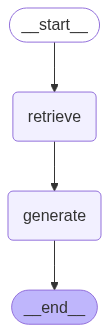

In [21]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    type: Annotated[
        Literal["text", "table", "image", "any"],
        ...,
        "Type of resource user most likely insterested in.",
    ]


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(
        state["question"],
        filter=get_search_filter(state),
    )
    return {"context": retrieved_docs}


def get_search_filter(state):
    if "query" not in state:
        return None
    query = state["query"]
    print(query)
    invalid_query = False
    if "type" in query:
        type = query["type"]
        if type in ("text", "table", "image"):
            return {"type": type}
        elif not type == "any":
            invalid_query = True
    else:
        invalid_query = True
    if invalid_query:
        print("Invalid query. Ignoring")
    return None


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
# graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
# graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

display(IPython.display.Image(graph.get_graph().draw_mermaid_png()))

The company made $4.728 billion in revenue for the year ended December 31, 2024, which represents a year-over-year increase of $37.4 million or 0.8%.

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

07e18acc-b434-4a1c-a137-c0b3e7c2f7db


**Full Year 2024 Highlights**


  - Revenues increased to $4.728 billion, a year-over-year increase of $37.4 million, or 0.8%. On an organic constant

currency basis, revenues declined 1.7% year-over-year;


  - We recorded a benefit of $68.8 million for research & development government incentives in Poland. Specifically,

$23.5 million of the benefit related to activities performed during 2023 and $45.3 million of the benefit related to
activities performed during the full year of 2024. This benefit was included as a reduction to our Cost of revenues.
The impact of this benefit on net income was partially offset as the incentives drove a higher effective tax rate for
both GAAP and non-GAAP results. We expect the incentive will be recurring with benefits recognized continuing in
the future;


  - GAAP income from operations was $544.6 million, an increase of $43.3 million, or 8.6%, compared to $501.2

million in 2023. GAAP income from operations benefited from the recognition of $68.8 million of incentives
related to research and development activities performed in Poland and was negatively impacted by $31.3 million
of costs incurred in connection with the Company's Cost Optimization Programs;


  - Non-GAAP income from operations was $779.2 million, an increase of $14.1 million, or 1.8%, compared to $765.1

million in 2023. Non-GAAP income from operations benefited from the recognition of $45.3 million of incentives
related to research and development activities performed in Poland in 2024;


  - Diluted EPS on a GAAP basis was $7.84, an increase of $0.78, or 11.0%, compared to $7.06 in 2023. EPS on a GAAP

basis was positively impacted by the recognition of the Polish incentives, which increased income from operations.
However, this benefit was partially offset by an increase to the effective tax rate; and


  - Non-GAAP diluted EPS was $10.86, an increase of $0.27, or 2.5%, compared to $10.59 in 2023. EPS on a non-GAAP

basis was positively impacted by the recognition of the Polish incentives for activities performed during the full
year of 2024, which increased income from operations. However, this benefit was partially offset by an increase to
the effective tax rate.




f3aaa02f-c77f-478d-b964-599fcf1bd891


**Cash Flow and Other Metrics**


  - Cash provided by operating activities was $130.3 million in the fourth quarter of 2024, a decrease from
$171.4 million in the fourth quarter of 2023; and was $559.2 million in 2024, a decrease from $562.6 million in
2023;


  - The Company repurchased 53 thousand shares of its common stock for $13.0 million during the fourth quarter of

2024 under its share repurchase program. During the year ended December 31, 2024, the Company repurchased
1,854 thousand shares of its common stock for $398.0 million under its share repurchase programs. As of
December 31, 2024, the Company had $437.0 million remaining under its share repurchase authorization;


  - Cash, cash equivalents and restricted cash totaled $1.290 billion as of December 31, 2024, a decrease of

$752.7 million, or 36.8%, from $2.043 billion as of December 31, 2023 largely the result of payments for the
acquisitions of NEORIS and First Derivative; and


  - Total headcount was approximately 61,200 as of December 31, 2024. Included in this number were approximately

55,100 delivery professionals, an increase of 16.3% from December 31, 2023.




e76b2e20-d05a-4e07-b865-d871666d8424


The image presents a detailed financial table from a PDF document, likely summarizing the balance sheet or financial position of a company. Here’s a breakdown of its components:

### Assets
1. **Current Assets:**
   - **Cash and Cash Equivalents:** $1,286,267 (2024) vs. $2,036,235 (2023)
   - **Trade Receivables and Contract Assets:** Itemized with an allowance of $5,612 (2024) and $11,864 (2023), totaling $1,002,175 versus $897,032.
   - **Short-term Investments:** $1,690 (2024) vs. $60,739 (2023).
   - **Prepaid and Other Current Assets:** $136,116 (2024) vs. a previous year's total not shown.
   - **Total Current Assets:** $2,426,248 (2024) vs. $3,931,661 (2023).

2. **Non-Current Assets:**
   - **Property, Plant, and Equipment:** $20,677 (2024) vs. $16,964 (2023).
   - **Operating Lease Right-of-Use Assets:** $128,244 (2024) vs. $134,888 (2023).
   - **Intangible Assets:** $436,614 (2024) vs. $71,118 (2023).
   - **Goodwill:** $1,181,575 (2024) vs. $562,459 (2023).
   - **Deferred Tax Assets:** $269,799 (2024) vs. $197,901 (2023).
   - **Other Noncurrent Assets:** $100,522 (2024) vs. $59,570 (2023).
   - **Total Assets:** $4,750,473 (2024) vs. $4,352,365 (2023).

### Liabilities
1. **Current Liabilities:**
   - **Accounts Payable:** $44,702 (2024) vs. $31,992 (2023).
   - **Accrued Compensation and Benefits Expenses:** $484,952 (2024) vs. $412,747 (2023).
   - **Accrued Expenses and Other Current Liabilities:** $20,315 (2024) vs. $128,423 (2023).
   - **Income Taxes Payable, Current:** $50,395 (2024) vs. $36,818 (2023).
   - **Operating Lease Liabilities, Current:** $39,634 (2024) vs. $36,562 (2023).
   - **Total Current Liabilities:** $821,630 (2024) vs. $646,392 (2023).

2. **Long-Term Liabilities:**
   - **Long-Term Debt:** $25,149 (2024) vs. $26,192 (2023).
   - **Operating Lease Liabilities, Noncurrent:** $98,426 (2024) vs. $109,261 (2023).
   - **Deferred Tax Liabilities, Noncurrent:** $92,360 (2024) vs. $9,874 (2023).
   - **Other Noncurrent Liabilities:** $82,301 (2024) vs. $91,832 (2023).
   - **Total Liabilities:** $1,119,322 (2024) vs. $880,895 (2023).

### Equity
- **Stockholders' Equity:**
  - Common stock, with details on shares issued and outstanding for both years.
  - **Additional Paid-in Capital:** $1,190,222 (2024) vs. $1,008,766 (2023).
  - **Retained Earnings:** $2,555,796 (2024) vs. $2,501,607 (2023).
  - **Accumulated Other Comprehensive Loss:** $3,629,411 (2024) vs. $3,479,091 (2023).
  - **Total Stockholders' Equity:** $3,631,541 (2024) vs. $2,471,470 (2023).

- **Total Liabilities and Equity:** $4,750,473 (2024) vs. $4,352,365 (2023).

This table provides a comprehensive overview of the company’s financial position across these two reporting periods, highlighting both the changes in assets and liabilities, as well as stockholders' equity.

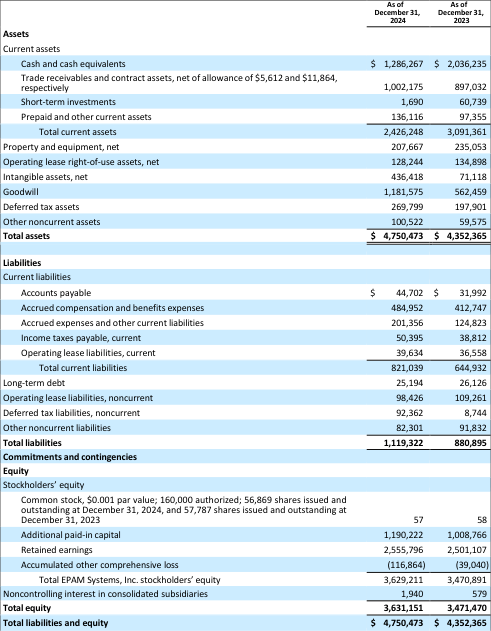

fb209b91-2a9c-47fa-9483-8c939ed1c099


The table presents key financial metrics related to revenue growth for two time frames: the three months and the year ended December 31, 2024. Here's a detailed breakdown:

1. **Header**: The top section identifies the reporting periods, with columns for "Three Months Ended December 31, 2024" and "Year Ended December 31, 2024."

2. **Metrics**: 
   - **Revenue growth as reported**: 
     - For the three months: 7.9%
     - For the year: 0.8%
   - **Foreign exchange rates impact**: 
     - Three months: 0.4%
     - Year: (0.1%)
   - **Inorganic revenue growth**: 
     - Three months: (7.3%)
     - Year: (2.7%)
   - **Impact of exit from Russia**: 
     - Three months: Not applicable (—)
     - Year: 0.3%
   - **Revenue growth/(decline) on an organic constant currency basis**: 
     - Three months: 1.0%
     - Year: (1.7%)

3. **Formatting**: 
   - The rows are clearly delineated with alternating background colors for ease of reading, primarily featuring light blue highlights for key boxes.
   - Negative values are presented in parentheses, indicating declines.

Overall, the table concisely summarizes revenue performance and the influences affecting it over the specified periods.

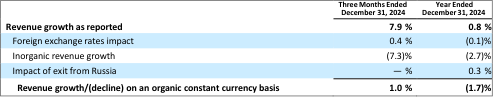

In [22]:
response = graph.invoke({"question": "How much money did the company make in the last year?"})
print(response["answer"])
print()
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
print()
display_documents(response["context"])

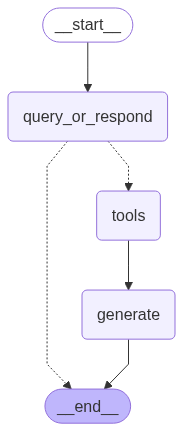

In [23]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
           or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile(checkpointer=MemorySaver())
config = {"configurable": {"thread_id": "1"}}

display(IPython.display.Image(graph.get_graph().draw_mermaid_png()))


In [24]:
input_message = "What did you say?"

for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What did you say?
================================== Ai Message ==================================

How can I assist you today? If you have a specific question or need information, feel free to ask!


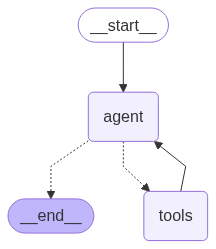

In [25]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=MemorySaver())
display(IPython.display.Image(agent_executor.get_graph().draw_mermaid_png()))
